In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from pmdarima.model_selection import train_test_split

import os
import sys

from arch import arch_model
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# stock_path = './Dataset/Stocks/'
stock_path = './Stocks_dow/'
img_path = './Images/'
DJ_path = './Dataset/Dow Jones/'
rf_path = './Dataset/US1M/'

In [3]:
class Strategy():
    def __init__(self, stock_path, train_start, train_end, test_start, test_end):
        self.stock_path = stock_path
        self.stock_list = os.listdir(stock_path)
        self.stock_list = [stock for stock in self.stock_list if stock.endswith('.csv')]  # filter out the csv files

        # time
        self.train_start = train_start
        self.train_end = train_end
        self.test_start = test_start
        self.test_end = test_end

        # price/volume data
        self.high = self.extract_data('High', train_start, test_end)
        self.low = self.extract_data('Low', train_start, test_end)
        self.open = self.extract_data('Open', train_start, test_end)
        self.close = self.extract_data('Close', train_start, test_end)
        self.volume = self.extract_data('Volume', train_start, test_end)
        self.adjclose = self.extract_data('Adj Close', train_start, test_end)

        # Dow Jones Index
        self.dj_index = pd.read_csv(DJ_path + 'DIA.csv')
        self.dj_index['Date'] = pd.to_datetime(self.dj_index['Date'])
        self.dj_index.set_index('Date', inplace=True)

        # risk-free rate
        self.rf = pd.read_csv(rf_path + 'DGS1MO.csv')
        self.rf['DATE'] = pd.to_datetime(self.rf['DATE'])
        self.rf.set_index('DATE', inplace=True)
        self.rf = self.rf.replace('.', np.nan).reindex(self.adjclose.index, method='ffill').astype(float) / 100

        # train/test data
        self.train_data = self.adjclose[(self.adjclose.index >= self.train_start) & (self.adjclose.index <= self.train_end)]
        self.test_data = self.adjclose[(self.adjclose.index >= self.test_start) & (self.adjclose.index <= self.test_end)]
        self.test_data = pd.concat([self.train_data.iloc[-1:], self.test_data], axis=0)
        self.dj_train = self.dj_index[(self.dj_index.index >= self.train_start) & (self.dj_index.index <= self.train_end)]
        self.dj_test = self.dj_index[(self.dj_index.index >= self.test_data.index[0]) & (self.dj_index.index <= self.test_end)]
        self.rf_train = self.rf[(self.rf.index >= self.train_start) & (self.rf.index <= self.train_end)]
        self.rf_test = self.rf[(self.rf.index >= self.test_data.index[0]) & (self.rf.index <= self.test_end)]
        
        # models
        self.scaler = None; self.pca = None; self.garch_model = None
        # daily return
        self.train_return = None; self.test_return = None
        # standardized return
        self.scaled_train = None; self.scaled_test = None
        # principal components
        self.pc_train = None; self.pc_test = None
        # market index
        self.train_index = None; self.test_index = None
        # weights
        self.weights_pc = None  # weights of each PC
        self.weights_stock = None  # weights of stocks in the index
        self.weight_stockpool = None  # investment weights in the stock pool in the prediction period

        self.forecast = None


    # =========================================================================
    # Data Tool
    # =========================================================================
    def extract_data(self, variable, start_date, end_date):
        '''
        extract specific data from our dataset
        '''
        for stock in self.stock_list:
            data = pd.read_csv(stock_path + stock)
            data['Date'] = pd.to_datetime(data['Date'])
            data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
            data = data[['Date', variable]]
            data = data.rename(columns={variable: stock[:-4]})
            if stock == self.stock_list[0]:
                df = data
            else:
                df = pd.merge(df, data, on='Date', how='left')
        df.set_index('Date', inplace=True)
        return df
    
    def drop_stock(self):
        '''
        drop stock which has missing values
        '''
        self.adjclose = self.adjclose.dropna(axis=1)
        self.stock_list = self.adjclose.columns.tolist()
        self.high = self.high[self.stock_list]
        self.low = self.low[self.stock_list]
        self.open = self.open[self.stock_list]
        self.close = self.close[self.stock_list]
        self.volume = self.volume[self.stock_list]

        self.train_data = self.adjclose[(self.adjclose.index >= self.train_start) & (self.adjclose.index <= self.train_end)]
        self.test_data = self.adjclose[(self.adjclose.index >= self.test_start) & (self.adjclose.index <= self.test_end)]
        self.test_data = pd.concat([self.train_data.iloc[-1:], self.test_data], axis=0)

    
    # =========================================================================
    # Market Index
    # =========================================================================
    def pca_analysis(self, n_components=10, save=False):
        '''
        PCA analysis for the stock market index
        : return: cumulative explained variance ratio
        '''
        # calculate the return
        self.train_return = self.train_data.pct_change().dropna()
        self.test_return = self.test_data.pct_change().dropna()

        # data standardization
        self.scaler = StandardScaler()
        self.scaled_train = self.scaler.fit_transform(self.train_data)
        self.scaled_train = pd.DataFrame(self.scaled_train, index=self.train_data.index, columns=self.train_data.columns)

        # PCA analysis
        pca = PCA(n_components=n_components)
        pca.fit(self.scaled_train)

        # explained variance ratio
        explained_variance_ratio = pca.explained_variance_ratio_

        if save:
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, n_components + 1), explained_variance_ratio, marker='o', color='skyblue')
            plt.xlabel('Principal Component')
            plt.ylabel('Explained Variance Ratio')
            plt.title('Explained Variance Ratio of Principal Components')
            plt.grid(linestyle='--', alpha=0.3)
            plt.savefig(img_path + 'explained_variance_ratio.png')

        return explained_variance_ratio.cumsum()
    
    def stock_weights(self, n_components=3, plot=True):
        '''
        compute the weights of each stock in the market index
        '''
        self.pca = PCA(n_components=n_components)
        self.pca.fit(self.scaled_train)

        # compute weight of each PC
        self.weights_pc = self.pca.explained_variance_ratio_
        self.weights_pc = self.weights_pc / self.weights_pc.sum()

        # compute the stock weights
        loadings = self.pca.components_.T  # loadings of each stock on each PC
        loadings_df = pd.DataFrame(loadings, index=self.stock_list, columns=['PC'+str(i) for i in range(1, n_components+1)])
        # weighted average of loadings
        loadings_df['Weighted Loadings'] = np.abs(np.sum(loadings_df * self.weights_pc, axis=1))
        # normalize the weighted loadings
        self.weights_stock = loadings_df['Weighted Loadings'] / np.sum(loadings_df['Weighted Loadings'])

        if plot:
            stock_weights = self.weights_stock.sort_values(ascending=False)
            plt.figure(figsize=(8, 8))
            plt.pie(stock_weights, labels=stock_weights.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues'))
            plt.title('Stock Weights in the Market Index')

        return self.weights_stock

    def market_volatility(self):
        market_index_volatility = np.zeros((len(self.forecast.columns), 1))
        corr = self.train_return.corr()
        # go through each forecast
        for i, col in enumerate(self.forecast.columns):
            self.weighted_vol = self.weights_stock.values * self.forecast[col]
            market_index_volatility[i] = np.sqrt(np.dot(np.dot(self.weighted_vol.values.T, corr), self.weighted_vol.values))
        market_index_volatility = pd.DataFrame(market_index_volatility)
        self.forcast_mktvol = market_index_volatility
        return market_index_volatility
    
    # =========================================================================
    # Volatility Prediction
    # =========================================================================
    def volatility_prediction(self, mean='Constant'):
        '''
        predict the volatility of the market index (GARCH model)
        : return: model summary & forecast
        '''
        pred_horizon = self.test_data.shape[0] - 1  # prediction horizon

        stock_return = 100 * self.train_data.pct_change().dropna()

        params = {}
        pvalues = {}
        forcast = {}

        for stock in self.stock_list:
            garch_model = arch_model(stock_return[stock], mean=mean, vol='Garch', p=1, q=1)
            garch_model = garch_model.fit(disp='off')
            params[stock] = garch_model.params
            pvalues[stock] = garch_model.pvalues
            forecast = garch_model.forecast(horizon=pred_horizon)
            forcast[stock] = forecast.variance.iloc[-1].values

        params_df = pd.DataFrame(params).T
        pvalues_df = pd.DataFrame(pvalues).T
        self.forecast = pd.DataFrame(forcast).T

        return params_df, pvalues_df, self.forecast
    def return_prediction(self):
        '''
        Predict returns using ARIMA model
        :return: model summary & forecasts
        '''
        # Define your prediction horizon
        pred_horizon = self.test_data.shape[0] -1 

        # Calculate stock returns
        stock_return = 100 * self.train_data.pct_change().dropna()

        # Initialize dictionaries to store parameters, p-values, and forecasts
        params = {}
        pvalues = {}
        forecasts = {}

        # Iterate over each stock
        for stock in self.stock_list:
            # Fit ARIMA model
            arima_model = pm.auto_arima(stock_return[stock], seasonal=False)
            
            # Store parameters
            params[stock] = arima_model.get_params()
            
            # Store p-values
            p_values = arima_model.pvalues()
            print("*****", p_values)
            pvalues[stock] = p_values

            # Make forecasts
            forecast = arima_model.predict(n_periods=pred_horizon)

            # Store forecasts
            forecasts[stock] = forecast

        # Convert dictionaries to DataFrames
        params_df = pd.DataFrame(params).T
        pvalues_df = pvalues
        forecast_df = pd.DataFrame(forecasts).T

        return params_df, pvalues_df, forecast_df
    
    # =========================================================================
    # Strategy
    # =========================================================================
    def strategy_1(self, h=0.5, _lambda=1):
        '''
        fixed function: market vol -> weights
        '''
        def weight_func(x, _lambda=_lambda):
            return (1 + h) * np.exp(-_lambda * x) / (h + np.exp(-_lambda * x))
        
        self.weight_stockpool = weight_func(self.forcast_mktvol)
        self.weight_stockpool.index = self.test_data.iloc[1:].index

        return self.weight_stockpool

    def strategy_2(self):
        pass        
        

    # =========================================================================
    # Performance Evaluation
    # =========================================================================
    def perf_eval(self, plot=True, save=True):
        '''
        calculate the performance of the strategy
        '''
        # portfolio return
        dj_return = self.dj_test['Adj Close'].pct_change().dropna()
        portfolio_return = self.weight_stockpool.values.flatten() * dj_return  + \
            (1 - self.weight_stockpool.values.flatten())  * self.rf_test.iloc[1:].mean().values[0] / 252
        # self.weight_stockpool * dj_return + (1 - self.weight_stockpool) * self.rf_test.iloc[1:].mean() / 252
        portfolio_cum_return = (portfolio_return + 1).cumprod()
        portfolio_nav = pd.Series(np.insert(portfolio_cum_return, 0, 1), index=self.test_data.index) * self.dj_test['Adj Close'].iloc[0]

        if plot:
            # plot
            plt.figure(figsize=(10, 6))
            plt.plot(portfolio_nav, label='Portfolio Nav', color='skyblue')
            plt.plot(self.dj_test['Adj Close'], label='DIA', color='orange')
            plt.xlabel('Date')
            plt.ylabel('Nav')
            plt.title('Performance of the Portfolio')
            plt.legend(loc='best')
            plt.grid(linestyle='--', alpha=0.3)
            if save:
                plt.savefig(img_path + 'portfolio_performance.png')
        
        # annualized sharpe ratio for the portfolio and dj
        excess_return = (portfolio_nav.iloc[-1] / portfolio_nav.iloc[0] - 1) * 12 - self.rf_test.iloc[1:].mean()
        return_vol = portfolio_return.std() * np.sqrt(12)
        sharpe_ratio = (excess_return / return_vol).values[0]
        sharpe_ratio_dj = ((self.dj_test['Adj Close'].iloc[-1] / self.dj_test['Adj Close'].iloc[0] - 1) * 12 - self.rf_test.iloc[1:].mean()) / (dj_return.std() * np.sqrt(12))
        sharpe_ratio_dj = sharpe_ratio_dj.values[0]

        # maximum drawdown
        max_drawdown = 1 - portfolio_nav / portfolio_nav.cummax()
        max_drawdown_dj = 1 - self.dj_test['Adj Close'] / self.dj_test['Adj Close'].cummax()

        eval_sheet = pd.DataFrame({'Monthly Return': [portfolio_nav.iloc[-1] / portfolio_nav.iloc[0] - 1, self.dj_test['Adj Close'].iloc[-1] / self.dj_test['Adj Close'].iloc[0] - 1],
                                   'Sharpe Ratio': [sharpe_ratio, sharpe_ratio_dj],
                                   'Max Drawdown': [max_drawdown.max(), max_drawdown_dj.max()]},
                                  index=['Portfolio', 'DIA'])

        return portfolio_nav, self.dj_test['Adj Close'], eval_sheet     
    

    # =========================================================================
    # Visualization Tool
    # =========================================================================
    def vis_nan(self):
        '''
        visualize the missing values in the dataset
        '''
        # the nan number of each column & plot
        nan_num = self.adjclose.isnull().sum() / self.adjclose.shape[0]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=nan_num.index, y=nan_num.values, color='skyblue')
        plt.xticks(rotation=90)
        plt.xlabel('Stock')
        plt.title('Missing Value Proportion of Each Stock')
        plt.grid(linestyle='--', alpha=0.3)
        # label the non-zero value
        for i, v in enumerate(nan_num):
            if v > 0:
                plt.text(i, v, round(v, 2), ha='center', va='bottom', fontsize=8)
        plt.savefig(img_path + 'missing_value_proportion.png')

In [4]:
train_start = pd.to_datetime('2012-01-01')
train_end = train_start + pd.DateOffset(years=10) - pd.DateOffset(days=1)  # training period: 10 years
test_start = train_end + pd.DateOffset(days=1)
test_end = test_start + pd.DateOffset(months=1) - pd.DateOffset(days=1)   # testing period: 1 month

print('Train Period:', train_start, 'to', train_end)
print('Test Period:', test_start, 'to', test_end)

model = Strategy(stock_path, train_start, train_end, test_start, test_end)

Train Period: 2012-01-01 00:00:00 to 2021-12-31 00:00:00
Test Period: 2022-01-01 00:00:00 to 2022-01-31 00:00:00


stock number: 30


FileNotFoundError: [Errno 2] No such file or directory: './Images/missing_value_proportion.png'

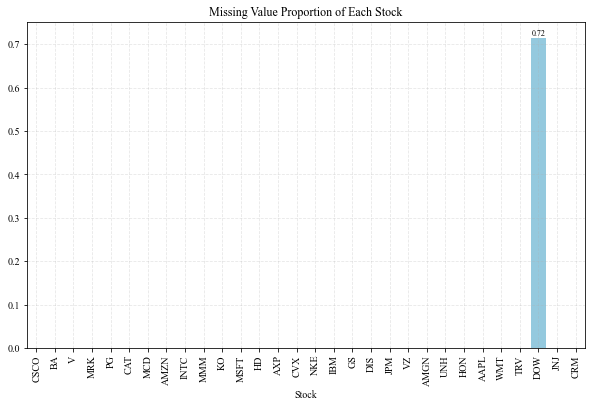

In [5]:
print('stock number:', len(model.stock_list))
model.vis_nan()   # we will not use DOW in our portfolio

In [6]:
model.drop_stock()   # according to the above figure, some stocks have too many missing values, so we drop them
print('stock number:', len(model.stock_list))

stock number: 29


In [7]:
model.pca_analysis()   # PCA analysis

array([0.84208154, 0.89391719, 0.94197713, 0.96025838, 0.96936386,
       0.97693598, 0.98152502, 0.98528824, 0.9882176 , 0.99033147])

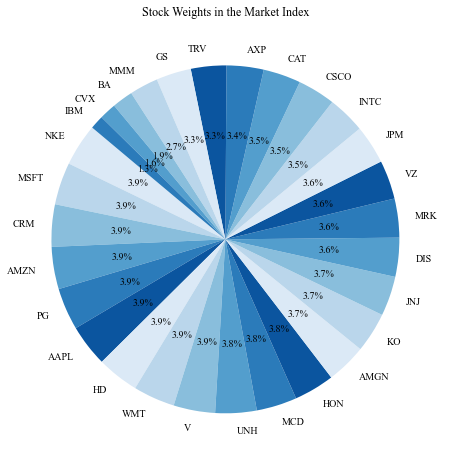

In [8]:
stock_weights = model.stock_weights(3, True)  # compute the weights of each stock in the market index

In [9]:
params_df, pvalues_df, forecast = model.volatility_prediction()  # volatility prediction
pvalues_df
print(forecast.shape)

(29, 20)


In [10]:
# Call the return_prediction method to get parameters, p-values, and forecasts
r_params, r_pvalues, r_forecast = model.return_prediction()


***** intercept     1.433062e-02
ar.L1         0.000000e+00
ar.L2        8.464875e-250
ma.L1         0.000000e+00
ma.L2        1.809350e-143
ma.L3         1.932883e-03
sigma2        0.000000e+00
dtype: float64
***** intercept    1.550983e-01
ar.L1        0.000000e+00
ar.L2        0.000000e+00
ar.L3        1.292200e-11
ar.L4        5.931808e-16
ar.L5        9.839539e-04
ma.L1        0.000000e+00
ma.L2        0.000000e+00
sigma2       0.000000e+00
dtype: float64
***** intercept    2.175971e-04
ar.L1        3.206553e-08
ar.L2        4.549202e-16
ar.L3        2.824850e-02
ar.L4        1.707351e-29
ma.L1        1.247755e-04
ma.L2        5.160938e-20
ma.L3        3.505178e-03
ma.L4        4.610455e-20
ma.L5        5.144358e-10
sigma2       0.000000e+00
dtype: float64
***** ar.L1     1.290989e-52
ar.L2     1.101865e-26
ar.L3     8.970625e-92
ma.L1     2.143697e-41
ma.L2     6.870300e-39
ma.L3     2.326121e-79
sigma2    0.000000e+00
dtype: float64
***** ar.L1      3.012248e-07
ar.L2      9.307

In [11]:
import pickle
def save_results( params_df, pvalues_df, forecast_df, params_file, pvalues_file, forecast_file):
        '''
        Save model results using pickle
        '''
        with open(params_file, 'wb') as f:
            pickle.dump(params_df, f)
        with open(pvalues_file, 'wb') as f:
            pickle.dump(pvalues_df, f)
        with open(forecast_file, 'wb') as f:
            pickle.dump(forecast_df, f)

def load_results( params_file, pvalues_file, forecast_file):
        '''
        Load model results using pickle
        '''
        with open(params_file, 'rb') as f:
            params_df = pickle.load(f)
        with open(pvalues_file, 'rb') as f:
            pvalues_df = pickle.load(f)
        with open(forecast_file, 'rb') as f:
            forecast_df = pickle.load(f)
        
        return params_df, pvalues_df, forecast_df
# Print or use the results as needed
# Save the results
params_file = 'params.pkl'
pvalues_file = 'pvalues.pkl'
forecast_file = 'forecast.pkl'
save_results(r_params, r_pvalues, r_forecast, params_file, pvalues_file, forecast_file)
r_params, r_pvalues, r_forecast=load_results(params_file, pvalues_file, forecast_file)

In [16]:
print(r_forecast)


          2516      2517      2518      2519      2520      2521      2522  \
CSCO  0.082402  0.029860  0.166730 -0.053914  0.210758 -0.054932  0.172169   
BA    0.081077  0.037247  0.068292  0.027109  0.037814  0.062867  0.097914   
V     0.243785  0.087093  0.296888 -0.002702  0.264846 -0.073600  0.170546   
MRK   0.226458 -0.211711  0.155750 -0.095650  0.018535  0.041496 -0.097226   
PG    0.031197 -0.079290  0.215990  0.015341  0.178158 -0.012499 -0.007151   
CAT   0.021617  0.078779  0.054711  0.043473  0.084723  0.024533  0.089595   
MCD  -0.004183 -0.036543  0.090006 -0.092209  0.114775 -0.077876  0.078854   
AMZN  0.234265  0.224411  0.215530  0.207528  0.200316  0.193816  0.187960   
INTC  0.105364  0.029297  0.037132  0.084096  0.032175  0.079115  0.042003   
MMM  -0.169189  0.112797 -0.038268 -0.038673  0.102894 -0.142757  0.152154   
KO    0.058762 -0.023774  0.098661 -0.013269  0.086027 -0.001847  0.075904   
MSFT  0.276411  0.098095  0.125494  0.121284  0.121931  0.121831

In [15]:
def save_results_csv( params_df, forecast_df, params_file, forecast_file):
        '''
        Save model results to CSV files
        '''
        params_df.to_csv(params_file, index=True)
        forecast_df.to_csv(forecast_file, index=True)

def load_results_csv( params_file, pvalues_file, forecast_file):
        '''
        Load model results from CSV files
        '''
        params_df = pd.read_csv(params_file)
        forecast_df = pd.read_csv(forecast_file)
        
        return params_df, pvalues_df, forecast_df

# Save the results
params_file_csv = 'params.csv'
pvalues_file_csv = 'pvalues.csv'
forecast_file_csv = 'forecast.csv'
save_results_csv(r_params, r_forecast, params_file_csv, forecast_file_csv)


In [ ]:
model.market_volatility()  # market index volatility

In [ ]:
model.strategy_1(h=0.1, _lambda=0.5)

In [ ]:
model.weight_stockpool

In [ ]:
portfolio_nav, market_index, eval_sheet  = model.perf_eval()

In [ ]:
eval_sheet

## Strategy: Monthly Adjustment

In [ ]:
# 2012-01-01 ~ 2013-12-01 freq=1M
start_time_list = pd.date_range(start='2012-01-01', end='2013-12-01', freq='MS')

# 存放月收益率
strategy_return_list = []
market_return_list = []
strategy_sharpe_list = []
market_sharpe_list = []
strategy_maxdrawdown_list = []
market_maxdrawdown_list = []

for i in range(len(start_time_list)):
    print('Start Time:', start_time_list[i])
    train_start = start_time_list[i]
    train_end = train_start + pd.DateOffset(years=10) - pd.DateOffset(days=1)
    test_start = train_end + pd.DateOffset(days=1)
    test_end = test_start + pd.DateOffset(months=1) - pd.DateOffset(days=1)

    model = Strategy(stock_path, train_start, train_end, test_start, test_end)
    model.drop_stock()
    vol_prop = model.pca_analysis()
    stock_w = model.stock_weights(3, False)
    params, pvalues, fore = model.volatility_prediction()  # volatility prediction
    pred_vol = model.market_volatility()
    index_w = model.strategy_1(h=0.1, _lambda=0.5)
    portfolio_nav, market_index, eval_sheet  = model.perf_eval(plot=False, save=False)
    strategy_return_list.append(eval_sheet.loc['Portfolio', 'Monthly Return'])
    market_return_list.append(eval_sheet.loc['DIA', 'Monthly Return'])   
    strategy_sharpe_list.append(eval_sheet.loc['Portfolio', 'Sharpe Ratio'])
    market_sharpe_list.append(eval_sheet.loc['DIA', 'Sharpe Ratio'])
    strategy_maxdrawdown_list.append(eval_sheet.loc['Portfolio', 'Max Drawdown'])
    market_maxdrawdown_list.append(eval_sheet.loc['DIA', 'Max Drawdown'])

# test_start_time_list = start_time_list + 10 years
test_start_time_list = start_time_list + pd.DateOffset(years=10)
strategy_return_list = pd.Series(strategy_return_list, index=test_start_time_list)
market_return_list = pd.Series(market_return_list, index=test_start_time_list)
strategy_sharpe_list = pd.Series(strategy_sharpe_list, index=test_start_time_list)
market_sharpe_list = pd.Series(market_sharpe_list, index=test_start_time_list)
strategy_maxdrawdown_list = pd.Series(strategy_maxdrawdown_list, index=test_start_time_list)
market_maxdrawdown_list = pd.Series(market_maxdrawdown_list, index=test_start_time_list)

In [ ]:
# plot strategy return and market return
plt.figure(figsize=(10, 6))
plt.plot(strategy_return_list, label='Portfolio Monthly Return', color='skyblue')
plt.plot(market_return_list, label='DIA Monthly Return', color='orange')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.title('Monthly Return of the Portfolio and DIA')
plt.legend(loc='best')
plt.grid(linestyle='--', alpha=0.3)

In [ ]:
# cumulative return
strategy_cum_return = (strategy_return_list + 1).cumprod()
# add 1 mon before the start time to the index
new_index = pd.date_range(start_time_list[0] - pd.DateOffset(months=1), periods=len(strategy_cum_return) + 1, freq='MS')
strategy_nav = pd.Series(np.insert(strategy_cum_return.values, 0, 1) * 100, index=new_index)
market_cum_return = (market_return_list + 1).cumprod()
market_nav = pd.Series(np.insert(market_cum_return.values, 0, 1) * 100, index=new_index)

# plot
plt.figure(figsize=(10, 6))
plt.plot(strategy_nav, label='Strategy', color='skyblue')
plt.plot(market_nav, label='DIA', color='orange')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of the Portfolio')
plt.legend(loc='best')
plt.grid(linestyle='--', alpha=0.3)
plt.show()

# calc sharpe ratio
strategy_excess_return = (strategy_cum_return.iloc[-1] - 1) / 2 - model.rf.mean() * 2
strategy_return_vol = strategy_return_list.std() * np.sqrt(0.5)
strategy_sharpe = (strategy_excess_return / strategy_return_vol).values[0]
# DIA sharpe ratio
market_excess_return = (market_cum_return.iloc[-1] - 1) / 2 - model.rf.mean() * 2
market_return_vol = market_return_list.std() * np.sqrt(0.5)
market_sharpe = (market_excess_return / market_return_vol).values[0]
print('Strategy Sharpe Ratio:', strategy_sharpe)
print('Market Sharpe Ratio:', market_sharpe)

In [ ]:
model.dj_index['Adj Close'].loc['2022-01-01':'2023-12-31'].plot()